In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GroupShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

DATA_DIR = "/content/drive/MyDrive/data"
SELECTED_ACTIVITIES = ["sit", "walk", "run", "stairs"]

TRAIN_POSITIONS = ["nondom_hand"]
TEST_POSITIONS = ["dom_hand", "dom_pocket", "nondom_pocket", "backpack"]

SAMPLING_RATE = 100
TRIM_SECONDS = 2
WINDOW_SIZE = SAMPLING_RATE
STEP_SIZE = SAMPLING_RATE // 2

BATCH_SIZE = 32
EPOCHS = 100
LR = 0.001
DROPOUT = 0.3
RANDOM_STATE = 42

RAW_FEATURES = ["ax", "ay", "az", "gx", "gy", "gz"]
GFT_FEATURES = ["ax_g", "ay_g", "az_g", "gx_g", "gy_g", "gz_g"]

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [3]:
def load_selected_csvs(base_dir):
    dfs = []
    all_needed_positions = list(set(TRAIN_POSITIONS + TEST_POSITIONS))
    for activity in SELECTED_ACTIVITIES:
        for position in all_needed_positions:
            path = os.path.join(base_dir, activity, position, "*.csv")
            for csv_path in glob.glob(path):
                try:
                    df = pd.read_csv(csv_path)
                    df["activity"] = activity
                    df["phone_position"] = position
                    df["recording_id"] = os.path.splitext(os.path.basename(csv_path))[0]
                    dfs.append(df)
                except Exception as e:
                    print(f"Error loading {csv_path}: {e}")
    print(f"Loaded {len(dfs)} recordings in total.")
    return dfs

def trim_df(df):
    trim = SAMPLING_RATE * TRIM_SECONDS
    if len(df) <= 2 * trim:
        return None
    return df.iloc[trim:-trim].reset_index(drop=True)

def sliding_windows(df):
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        yield df.iloc[start:start + WINDOW_SIZE]

def build_dataset(dfs, feature_cols):
    X, y, groups = [], [], []
    for df in dfs:
        df = trim_df(df)
        if df is None:
            continue
        for w in sliding_windows(df):
            X.append(w[feature_cols].values)
            y.append(w["activity"].iloc[0])
            groups.append(w["recording_id"].iloc[0])
    if len(X) == 0:
        return np.array([]), np.array([]), np.array([])
    X = np.array(X)
    y = np.array(y)
    groups = np.array(groups)
    return X, y, groups

class MotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
class DepthwiseSeparableConv1D(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding=0):
        super().__init__()
        self.depthwise = nn.Conv1d(in_ch, in_ch, kernel_size=kernel_size, padding=padding, groups=in_ch)
        self.pointwise = nn.Conv1d(in_ch, out_ch, kernel_size=1)
        self.bn = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return self.relu(x)

class DS1DCNNClassifier(nn.Module):
    def __init__(self, num_features, num_classes, dropout):
        super().__init__()
        self.features = nn.Sequential(
            DepthwiseSeparableConv1D(num_features, 64, kernel_size=7, padding=3),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),

            DepthwiseSeparableConv1D(64, 128, kernel_size=5, padding=2),
            nn.MaxPool1d(2),
            nn.ReLU(),
            nn.Dropout(dropout),

            DepthwiseSeparableConv1D(128, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.features(x)
        x = self.global_pool(x).squeeze(-1)
        return self.classifier(x)

In [6]:
def train_model(X_train, y_train, X_val, y_val, num_classes):
    scaler = StandardScaler()
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    scaler.fit(X_train_flat)
    X_train = scaler.transform(X_train_flat).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

    train_loader = DataLoader(MotionDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(MotionDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = DS1DCNNClassifier(num_features=X_train.shape[2], num_classes=num_classes, dropout=DROPOUT).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    best_loss = np.inf
    best_state = None

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_loss += criterion(preds, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_state = model.state_dict()

    model.load_state_dict(best_state)
    return model

def run_cross_position_experiment(all_dfs, feature_cols, title_suffix):
    print(f"\n{'='*20}\nRunning: {title_suffix}\n{'='*20}")

    train_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TRAIN_POSITIONS]
    test_dfs = [df for df in all_dfs if df["phone_position"].iloc[0] in TEST_POSITIONS]

    if not train_dfs or not test_dfs:
        print("Error: Missing data for either train or test positions.")
        return

    X_train_full, y_train_full, g_train_full = build_dataset(train_dfs, feature_cols)
    X_test, y_test, _ = build_dataset(test_dfs, feature_cols)

    if len(X_train_full) == 0 or len(X_test) == 0:
        print("Error: Not enough data after windowing.")
        return

    le = LabelEncoder()
    le.fit(SELECTED_ACTIVITIES)
    y_train_full_enc = le.transform(y_train_full)
    y_test_enc = le.transform(y_test)

    splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
    train_idx, val_idx = next(splitter.split(X_train_full, y_train_full_enc, g_train_full))

    X_train, y_train = X_train_full[train_idx], y_train_full_enc[train_idx]
    X_val, y_val = X_train_full[val_idx], y_train_full_enc[val_idx]

    model = train_model(X_train, y_train, X_val, y_val, num_classes=len(le.classes_))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loader = DataLoader(MotionDataset(X_test, y_test_enc), batch_size=BATCH_SIZE, shuffle=False)

    preds, trues = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            out = model(xb)
            preds.extend(out.argmax(1).cpu().numpy())
            trues.extend(yb.numpy())

    print(f"\n=== Classification Report: {title_suffix} ===")
    print(f"Train Pos: {TRAIN_POSITIONS}")
    print(f"Test Pos:  {TEST_POSITIONS}")
    print(classification_report(trues, preds, target_names=le.classes_, digits=4))

    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=le.classes_,
                yticklabels=le.classes_,
                cmap="Oranges")
    plt.title(f"{title_suffix}\nTrain: {TRAIN_POSITIONS} -> Test: {TEST_POSITIONS}")
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

Loaded 100 recordings in total.

Running: DS1D CNN – Raw Features

=== Classification Report: DS1D CNN – Raw Features ===
Train Pos: ['nondom_hand']
Test Pos:  ['dom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
              precision    recall  f1-score   support

         run     0.0048    0.0060    0.0054      1000
         sit     0.0000    0.0000    0.0000      1000
      stairs     0.3235    0.8814    0.4733      1020
        walk     0.0000    0.0000    0.0000      1000

    accuracy                         0.2251      4020
   macro avg     0.0821    0.2218    0.1197      4020
weighted avg     0.0833    0.2251    0.1214      4020



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


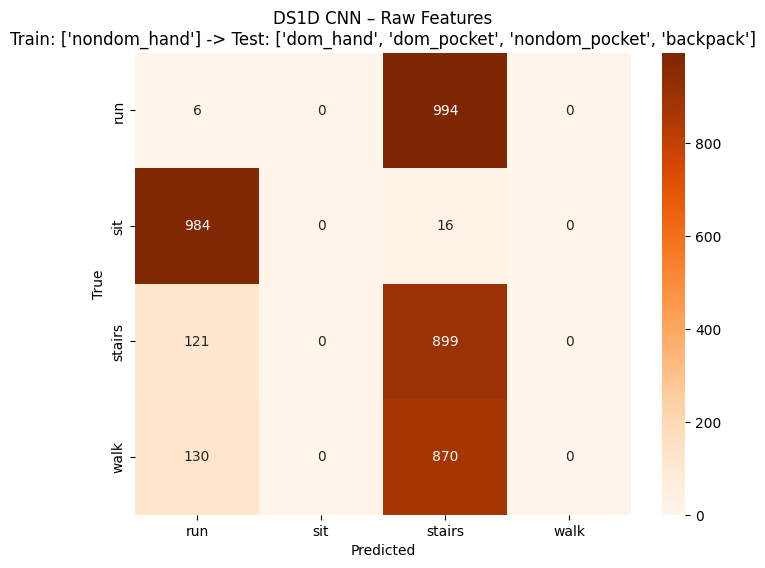


Running: DS1D CNN – GFT Features

=== Classification Report: DS1D CNN – GFT Features ===
Train Pos: ['nondom_hand']
Test Pos:  ['dom_hand', 'dom_pocket', 'nondom_pocket', 'backpack']
              precision    recall  f1-score   support

         run     0.3659    0.7680    0.4956      1000
         sit     0.0000    0.0000    0.0000      1000
      stairs     0.3712    0.6990    0.4849      1020
        walk     0.0000    0.0000    0.0000      1000

    accuracy                         0.3684      4020
   macro avg     0.1843    0.3668    0.2451      4020
weighted avg     0.1852    0.3684    0.2463      4020



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


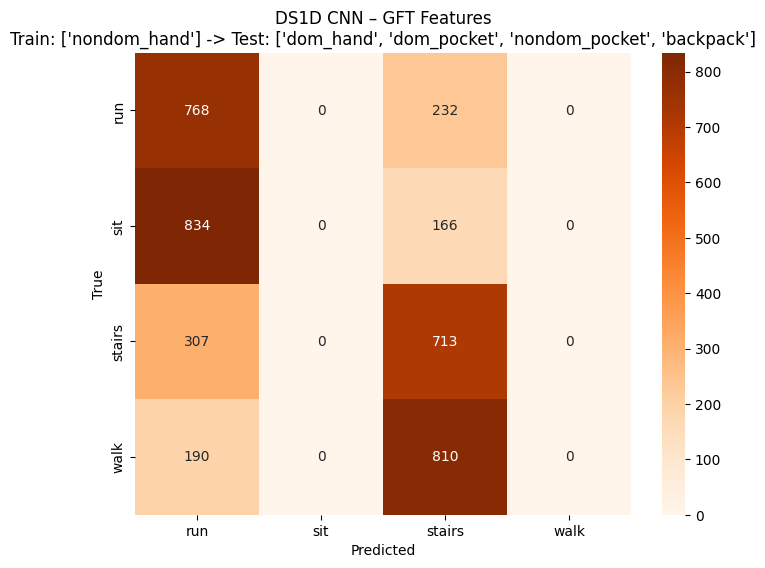

In [13]:
if __name__ == "__main__":
    all_recordings = load_selected_csvs(DATA_DIR)

    if all_recordings:
        run_cross_position_experiment(all_recordings, RAW_FEATURES, "DS1D CNN – Raw Features")
        run_cross_position_experiment(all_recordings, GFT_FEATURES, "DS1D CNN – GFT Features")